In [22]:
import requests
import pandas as pd
import json
import io
import itertools
import datetime
import numpy as np
import math
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
full_game_logs_df = pd.read_csv('data-full/2021_22_NBA_REG_GAME_LOGS_COMBINED.csv')

In [16]:
full_game_logs_df

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,PW_POS,PW_PF,PW_PFD,PW_FGM_PAINT,PW_FGM_2PT_MR,PW_PIE_AVG,PW_USG_PCT_AVG,CAREER_INJURIES,DAYS_LAST_INJURY,OUT_NEXT_GAME
0,2021-22,203497,Rudy Gobert,1610612762,UTA,Utah Jazz,22101230,2022-04-10T00:00:00,UTA @ POR,W,...,198,11,21,19.0,0.0,0.169333,0.200000,24,16,0
1,2021-22,203903,Jordan Clarkson,1610612762,UTA,Utah Jazz,22101230,2022-04-10T00:00:00,UTA @ POR,W,...,167,1,5,7.0,0.0,0.139000,0.223667,7,70,0
2,2021-22,1628384,O.G. Anunoby,1610612761,TOR,Toronto Raptors,22101226,2022-04-10T00:00:00,TOR @ NYK,L,...,0,0,0,0.0,0.0,0.000000,0.000000,22,9,0
3,2021-22,1627751,Jakob Poeltl,1610612759,SAS,San Antonio Spurs,22101219,2022-04-10T00:00:00,SAS @ DAL,L,...,116,7,8,11.0,1.0,0.157500,0.236000,12,3,0
4,2021-22,1630170,Devin Vassell,1610612759,SAS,San Antonio Spurs,22101219,2022-04-10T00:00:00,SAS @ DAL,L,...,200,4,4,4.0,2.0,0.131667,0.182000,9,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6541,2021-22,201939,Stephen Curry,1610612744,GSW,Golden State Warriors,22100002,2021-10-19T00:00:00,GSW @ LAL,W,...,0,0,0,0.0,0.0,0.000000,0.000000,58,158,0
6542,2021-22,1629673,Jordan Poole,1610612744,GSW,Golden State Warriors,22100002,2021-10-19T00:00:00,GSW @ LAL,W,...,0,0,0,0.0,0.0,0.000000,0.000000,2,598,0
6543,2021-22,203110,Draymond Green,1610612744,GSW,Golden State Warriors,22100002,2021-10-19T00:00:00,GSW @ LAL,W,...,0,0,0,0.0,0.0,0.000000,0.000000,45,158,0
6544,2021-22,203952,Andrew Wiggins,1610612744,GSW,Golden State Warriors,22100002,2021-10-19T00:00:00,GSW @ LAL,W,...,0,0,0,0.0,0.0,0.000000,0.000000,13,158,0


In [17]:
full_game_logs_df.columns

Index(['SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP',
       'WL', 'MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB',
       'AST', 'TOV', 'STL', 'BLK', 'PF', 'PFD', 'PTS', 'USG_PCT', 'PIE',
       'POSS', 'PTS_PAINT', 'PCT_PTS_2PT_MR', 'AGE', 'PLAYER_HEIGHT_INCHES',
       'PLAYER_WEIGHT', 'FGM_PAINT', 'FGM_2PT_MR', 'PW_MIN', 'PW_GAMES',
       'PW_FG3A', 'PW_FG2A', 'PW_OREB', 'PW_DREB', 'PW_ASTS', 'PW_TOV',
       'PW_STL', 'PW_BLK', 'PW_POS', 'PW_PF', 'PW_PFD', 'PW_FGM_PAINT',
       'PW_FGM_2PT_MR', 'PW_PIE_AVG', 'PW_USG_PCT_AVG', 'CAREER_INJURIES',
       'DAYS_LAST_INJURY', 'OUT_NEXT_GAME'],
      dtype='object')

In [28]:
# get subset of numerical game stats
# remove FG3M, FTM, FGM as they were used to calculate FGM_PAINT, FGM_2PT_MR, PW_FGM_PAINT, PW_FGM_2PT_MR
# remove PTS as FGA, FTA shot attempts better encapsulate court activity
game_logs_subset = ['MIN', 'FGA', 'FG3A', 'FTA', 'OREB', 'DREB',
       'AST', 'TOV', 'STL', 'BLK', 'PF', 'PFD', 'USG_PCT', 'PIE',
       'POSS', 'PTS_PAINT', 'PCT_PTS_2PT_MR', 'AGE', 'PLAYER_HEIGHT_INCHES',
       'PLAYER_WEIGHT', 'FGM_PAINT', 'FGM_2PT_MR', 'PW_MIN', 'PW_GAMES',
       'PW_FG3A', 'PW_FG2A', 'PW_OREB', 'PW_DREB', 'PW_ASTS', 'PW_TOV',
       'PW_STL', 'PW_BLK', 'PW_POS', 'PW_PF', 'PW_PFD', 'PW_FGM_PAINT',
       'PW_FGM_2PT_MR', 'PW_PIE_AVG', 'PW_USG_PCT_AVG', 'CAREER_INJURIES',
       'DAYS_LAST_INJURY', 'OUT_NEXT_GAME']

In [29]:
game_logs_data = full_game_logs_df[game_logs_subset]

In [34]:
game_logs_data.columns

Index(['MIN', 'FGA', 'FG3A', 'FTA', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK',
       'PF', 'PFD', 'USG_PCT', 'PIE', 'POSS', 'PTS_PAINT', 'PCT_PTS_2PT_MR',
       'AGE', 'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT', 'FGM_PAINT',
       'FGM_2PT_MR', 'PW_MIN', 'PW_GAMES', 'PW_FG3A', 'PW_FG2A', 'PW_OREB',
       'PW_DREB', 'PW_ASTS', 'PW_TOV', 'PW_STL', 'PW_BLK', 'PW_POS', 'PW_PF',
       'PW_PFD', 'PW_FGM_PAINT', 'PW_FGM_2PT_MR', 'PW_PIE_AVG',
       'PW_USG_PCT_AVG', 'CAREER_INJURIES', 'DAYS_LAST_INJURY',
       'OUT_NEXT_GAME'],
      dtype='object')

In [31]:
game_logs_data.corr()

,MIN,FGA,FG3A,FTA,OREB,DREB,AST,TOV,STL,BLK,...,PW_POS,PW_PF,PW_PFD,PW_FGM_PAINT,PW_FGM_2PT_MR,PW_PIE_AVG,PW_USG_PCT_AVG,CAREER_INJURIES,DAYS_LAST_INJURY,OUT_NEXT_GAME
MIN,1.000000,0.608250,0.312010,0.356537,0.095261,0.291103,0.379717,0.313444,0.182598,0.083748,...,0.202770,0.080586,0.268620,0.210391,0.236723,0.196663,0.255916,0.102837,-0.018181,-0.091352
FGA,0.608250,1.000000,0.510324,0.418409,0.064985,0.205735,0.347675,0.327816,0.129654,-0.001627,...,0.149143,0.041314,0.365431,0.289262,0.362156,0.260141,0.491379,0.067488,-0.032548,-0.021482
FG3A,0.312010,0.510324,1.000000,0.015957,-0.289188,-0.149795,0.168202,0.113735,0.067408,-0.163543,...,0.052812,-0.080306,-0.041156,-0.183129,0.053244,-0.070011,0.181910,-0.027019,-0.014426,-0.023960
FTA,0.356537,0.418409,0.015957,1.000000,0.136398,0.270000,0.218620,0.276458,0.076729,0.106150,...,0.082175,0.067206,0.432734,0.315792,0.213510,0.300411,0.348289,0.114639,-0.049906,-0.010138
OREB,0.095261,0.064985,-0.289188,0.136398,1.000000,0.317061,-0.087881,0.024319,-0.003838,0.258719,...,0.003080,0.130314,0.116504,0.253829,-0.105943,0.173395,-0.029297,0.000700,0.005369,-0.020869
DREB,0.291103,0.205735,-0.149795,0.270000,0.317061,1.000000,0.095661,0.197420,0.037742,0.266790,...,0.049477,0.135334,0.261246,0.309832,0.047321,0.311458,0.147159,0.091300,0.042182,-0.037476
AST,0.379717,0.347675,0.168202,0.218620,-0.087881,0.095661,1.000000,0.338475,0.175696,-0.074818,...,0.104517,-0.010384,0.240075,0.125859,0.261829,0.207011,0.274306,0.155192,-0.051418,-0.001282
TOV,0.313444,0.327816,0.113735,0.276458,0.024319,0.197420,0.338475,1.000000,0.088553,0.007576,...,0.081168,0.051072,0.279136,0.198329,0.187306,0.228667,0.312578,0.089915,0.006965,-0.004763
STL,0.182598,0.129654,0.067408,0.076729,-0.003838,0.037742,0.175696,0.088553,1.000000,0.016364,...,0.016375,0.025111,0.039062,0.008011,0.039310,0.055577,0.040651,0.066148,0.004141,-0.020853
BLK,0.083748,-0.001627,-0.163543,0.106150,0.258719,0.266790,-0.074818,0.007576,0.016364,1.000000,...,-0.043577,0.072054,0.064707,0.130205,-0.068650,0.126533,-0.014008,0.093931,-0.022348,-0.011644


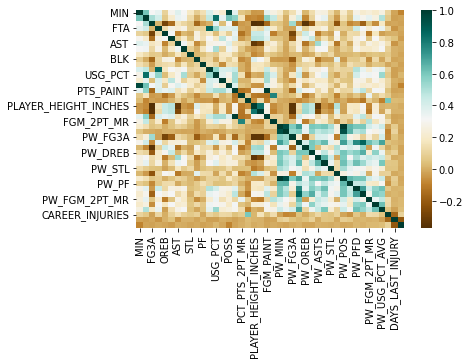

In [32]:
sns.heatmap(game_logs_data.corr(), cmap='BrBG');

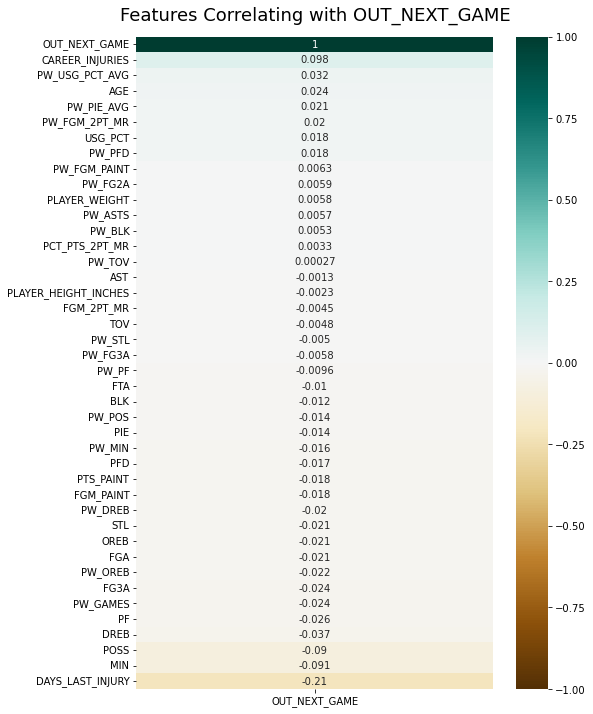

In [33]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(game_logs_data.corr()[['OUT_NEXT_GAME']].sort_values(by='OUT_NEXT_GAME', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with OUT_NEXT_GAME', fontdict={'fontsize':18}, pad=16);

In [ ]:
# do we need to standardize anything?
# do not standarize: USG_PCT, PIE, PW_PIE_AVG, PW_USG_PCT_AVG

In [35]:
game_logs_data.columns

Index(['MIN', 'FGA', 'FG3A', 'FTA', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK',
       'PF', 'PFD', 'USG_PCT', 'PIE', 'POSS', 'PTS_PAINT', 'PCT_PTS_2PT_MR',
       'AGE', 'PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT', 'FGM_PAINT',
       'FGM_2PT_MR', 'PW_MIN', 'PW_GAMES', 'PW_FG3A', 'PW_FG2A', 'PW_OREB',
       'PW_DREB', 'PW_ASTS', 'PW_TOV', 'PW_STL', 'PW_BLK', 'PW_POS', 'PW_PF',
       'PW_PFD', 'PW_FGM_PAINT', 'PW_FGM_2PT_MR', 'PW_PIE_AVG',
       'PW_USG_PCT_AVG', 'CAREER_INJURIES', 'DAYS_LAST_INJURY',
       'OUT_NEXT_GAME'],
      dtype='object')